In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler
import pandas as pd
sys.path.append(os.path.dirname(os.getcwd()))
from functions_roman_rubin import sim_fit,sim_event
from functions_roman_rubin import model_rubin_roman, fit_rubin_roman
from functions_roman_rubin import read_data, save


/home/anibal-pc/roman_rubin


In [2]:

current_path = os.path.dirname(os.getcwd())
# print(current_path)
i=18 #select one event by its index in the TRILEGAL set
model='USBL'

path_TRILEGAL_set= current_path+'/TRILEGAL/PB_planet_split_1.csv'
path_to_save_model= current_path+'/test_sim_fit/'
path_to_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
path_fit_rr = path_to_save_fit+f'/Event_RR_{i}_TRF.npy'
path_fit_roman =  path_to_save_fit+f'/Event_Roman_{i}_TRF.npy'
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

### The event that we want to simulate have the following parameters

In [3]:
pd_planets = pd.read_csv(path_TRILEGAL_set)
event_params = pd_planets.iloc[int(i)]
print(event_params)

u                                  24.853
g                                   22.55
r                                  21.529
i                                  21.133
z                                  20.945
Y                                  20.828
W149                              20.8178
radius                           0.513042
D_S                                  5156
D_L                                  2817
mu_rel                           5.147491
m_planet    9.462530108421484 jupiterMass
m_star          18.65259824621826 solMass
t0                         2462592.427461
te                             351.034363
u0                               0.147437
rho                              0.000094
piEE                            -0.032015
piEN                             0.005886
s                                 1.14786
q                                0.000484
alpha                            2.170221
Name: 18, dtype: object


## First we simulate the event 
The relevant code for this is the function sim_event(i, event_params, path_ephemerides, path_dataslice, model).

The output:

model(eg: pyLIMA.models.USBL_model.USBLmodel): the light curves, telescope name, etc.  
pyLIMA_parameters (dictionary): PyLIMA parameters.
decision (boolean): is made based on the detection criteria. This boolean is True if the event is a suitable candidate for fitting.

In [4]:

my_own_model, pyLIMA_parameters, decision = sim_event(i, event_params, path_ephemerides, path_dataslice,model)

/home/anibal-pc/roman_rubin


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: 

Parallax(Full) estimated for the telescope W149: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 12 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERF

Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
['third_caustic', [0, 0]]
A good event to fit


In [5]:
print('if the criterias are satisfied by this event we obtain "True":', decision)

if the criterias are satisfied by this event we obtain "True": True


In [6]:
if decision:
    print("Save the simulated event")
    save(i, path_TRILEGAL_set, path_to_save_model, my_own_model, pyLIMA_parameters)



Save the simulated event
Saving...
File saved: /home/anibal-pc/roman_rubin/test_sim_fit/Event_18.h5


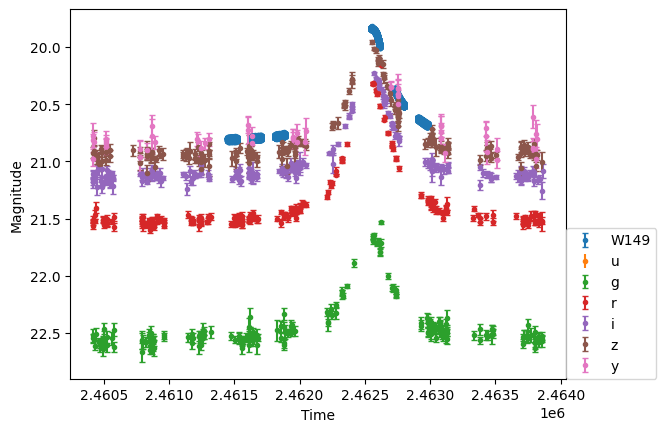

In [7]:
#plot without alignment

telescopes = my_own_model.event.telescopes

for telo in telescopes:
    plt.errorbar(telo.lightcurve_magnitude['time'],telo.lightcurve_magnitude['mag'],telo.lightcurve_magnitude['err_mag'],ls='',marker='.',capsize=2,label=telo.name)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc=(1,0))
plt.gca().invert_yaxis()
plt.show()

## Plot this event with pyLIMA

We can use the functionality of pyLIMA to make plot with aligned data in order to see the peak asociated to a planet of this particular event

Comment on pyLIMA:

To plot these events, since in our model we use the positions of Gaia with a shift in time,
it is necessary to modify the pyLIMA code as follows:

 In /pyLIMA/toolbox/fake_telescopes.py, we must add 'spacecraft_positions' to the list
 in the function:

 replicate_a_telescope(microlensing_model, telescope_index, light_curve_time=None,
                        astrometry_curve_time=None):

 attributes_to_copy = ['name', 'filter', 'location', 'ld_gamma', 'ld_sigma', 'ld_a1',
                       'ld_a2', 'ld_gamma1', 'ld_gamma2', 'location', 'spacecraft_name',
                       'spacecraft_positions', 'pixel_scale']



In [8]:
info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')
ulens_params = []
PAR = ['t_center','u_center','tE','rho','separation','mass_ratio','alpha','piEN','piEE']

for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []

# Here we change the zero point to the pyLIMA convention in order to make the alignment
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params


In [9]:
model_ulens = 'USBL'

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
event_params['s']=event_params['separation']
event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)


check_event  : Everything looks fine...


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g (Rubin): SUCCESS
Parallax(Full) estimated for the telescope r (Rubin): SUCCESS
Parallax(Full) estimated for the telescope i (Rubin): SUCCESS
Parallax(Full) estimated for the telescope z (Rubin): SUCCESS
Parallax(Full) estimated for the telescope y (Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA 

In [10]:

if len(true_params) != len(model_true.model_dictionnary):
    telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
    telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
                         telescopes_fluxes]#._fields]
    model_parameters3 = np.r_[true_params, telescopes_fluxes]
else:
    model_parameters3 = true_params


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 92359 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 92359 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 72585 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 72585 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 72585 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope g (Rubin): SUCCESS


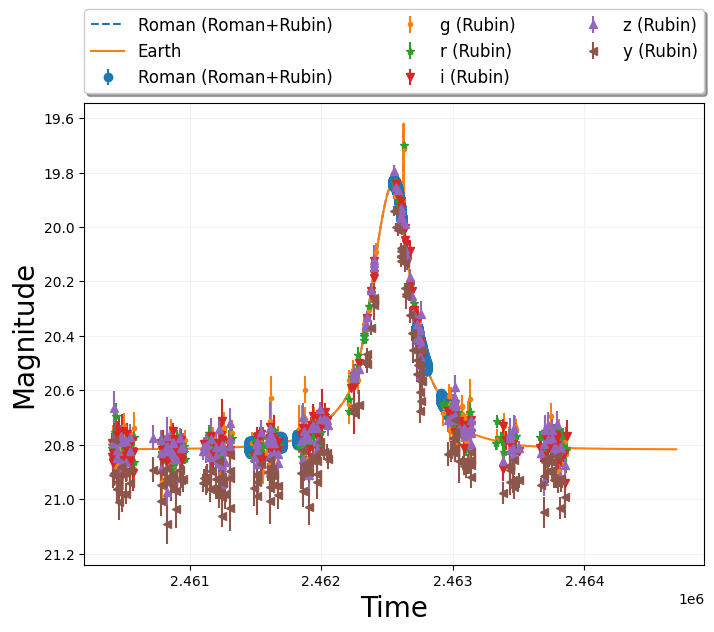

In [11]:
fig, axes = plt.subplots(1, 1,figsize=(8,6))

axes.set_ylabel("Magnitude",fontsize=20)
axes.set_xlabel("Time",fontsize=20)
axes.grid(True, color='0.95')
axes.invert_yaxis()
# axes.set_title('Simulated event')


pyLIMA_plots.plot_photometric_models(axes, model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes, model_true, true_params, plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

axes.legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()


# Fits

Relevant Function: 

fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,
                               band_roman, band_rubin_u, band_rubin_g, band_rubin_r,
                                           band_rubin_i, band_rubin_z, band_rubin_y)

This function performs the fitting of microlensing events using data from both the Rubin Observatory (LSST) and the Roman Space Telescope (WFIRST). It supports various microlensing models, including Finite-Source Point Lens (FSPL), Uniform Source Binary Lens (USBL), and Point Source Point Lens (PSPL). Additionally, the function accommodates multiple fitting algorithms, such as Trust Region Reflective (TRF), Markov Chain Monte Carlo (MCMC), and Differential Evolution (DE).

The boundaries used for the fitting process can be modified within the function's script.



In [12]:
algo='TRF'

Source = i
if decision:
    lc_to_fit = {}
    for telo in my_own_model.event.telescopes:
        if not len(telo.lightcurve_magnitude['mag'])==0:
            df = telo.lightcurve_magnitude.to_pandas()
            lc_to_fit[telo.name] = df.values
        else:
            lc_to_fit[telo.name] = []
    origin = my_own_model.origin
    rango = 1
    fit_rr, event_fit_rr, pyLIMAmodel_rr = fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,rango,
                               lc_to_fit["W149"], lc_to_fit["u"], lc_to_fit["g"], lc_to_fit["r"],
                                           lc_to_fit["i"], lc_to_fit["z"],lc_to_fit["y"])
    fit_roman, event_fit_roman, pyLIMAmodel_roman = fit_rubin_roman(Source,event_params, path_to_save_fit, path_ephemerides,model,algo,origin,rango,
                               lc_to_fit["W149"], [], [], [], [], [],[])


check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 25 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 25 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 25 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 261.92332561608146, 227.1020197745454, 49.16169266311294, 44.95377491290438, 198.17008039184716, 115.85956729838873, 182.22793064946242, 166.46665663900635, 228.6265740239188, 198.9413151678031, 276.50461678243636, 218.25714149463693]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2462549.3246654384, 0.3040304105522466, 397.977777084771, 6.334538742966774e-05, 1.1475543547636977, 0.0005221924957136528, 2.194934049694147, 0.007024079865915556, -0.03225635359861147, 263.59654036072675, 429.4358160247384, 46.632784045003966, 86.95895238584949, 191.67939220336174, 222.9439451259018, 175.31133655691346, 321.4354884636423, 221.96631152556074, 381.0590794611577, 253.07960517653459, 417.03509388981814] chi2 42746.65606806868
check_event  : 

In [13]:
#we can make some tests to check if this is a good event before make the plot
from scipy.stats import chi2
chi2_roman = fit_roman.fit_results['chi2']
DOF_roman = len(pyLIMAmodel_roman.event.telescopes[0].lightcurve_magnitude['time'])-len(fit_roman.fit_results['best_model'])
print('Chi square reduced for Roman', chi2_roman/DOF_roman)
print('p-value of a chi squared test', chi2.sf(chi2_roman, DOF_roman))
print('We see a very low p-value this indicates that is unlikely that the model follow the data.')
# #metrics

#metric alpha
alpha_roman = abs(np.array(true_params[0:len(fit_roman.fit_results['best_model'])])-fit_roman.fit_results['best_model'])/np.array(true_params[0:len(fit_roman.fit_results['best_model'])]) 
alpha_rr = (abs(np.array(true_params[0:len(fit_rr.fit_results['best_model'])])-fit_rr.fit_results['best_model'])/np.array(true_params[0:len(fit_rr.fit_results['best_model'])]))[0:len(fit_roman.fit_results['best_model'])]
#metric beta
beta_roman = abs(np.array(true_params[0:len(fit_roman.fit_results['best_model'])])-fit_roman.fit_results['best_model'])/abs(np.sqrt(np.diag(fit_roman.fit_results['covariance_matrix'])))
beta_rr = (abs(np.array(true_params[0:len(fit_rr.fit_results['best_model'])])-fit_rr.fit_results['best_model'])/np.sqrt(np.diag(fit_rr.fit_results['covariance_matrix'])))[0:len(fit_roman.fit_results['best_model'])]
#metric gamma
gamma_roman = np.sqrt(np.diag(fit_roman.fit_results['covariance_matrix']))/np.array(true_params[0:len(fit_roman.fit_results['best_model'])])
gamma_rr = (np.sqrt(np.diag(fit_rr.fit_results['covariance_matrix']))/np.array(true_params[0:len(fit_rr.fit_results['best_model'])]))[0:len(fit_roman.fit_results['best_model'])]



Chi square reduced for Roman 1.0083662449131534
p-value of a chi squared test 0.11411376524991317
We see a very low p-value this indicates that is unlikely that the model follow the data.


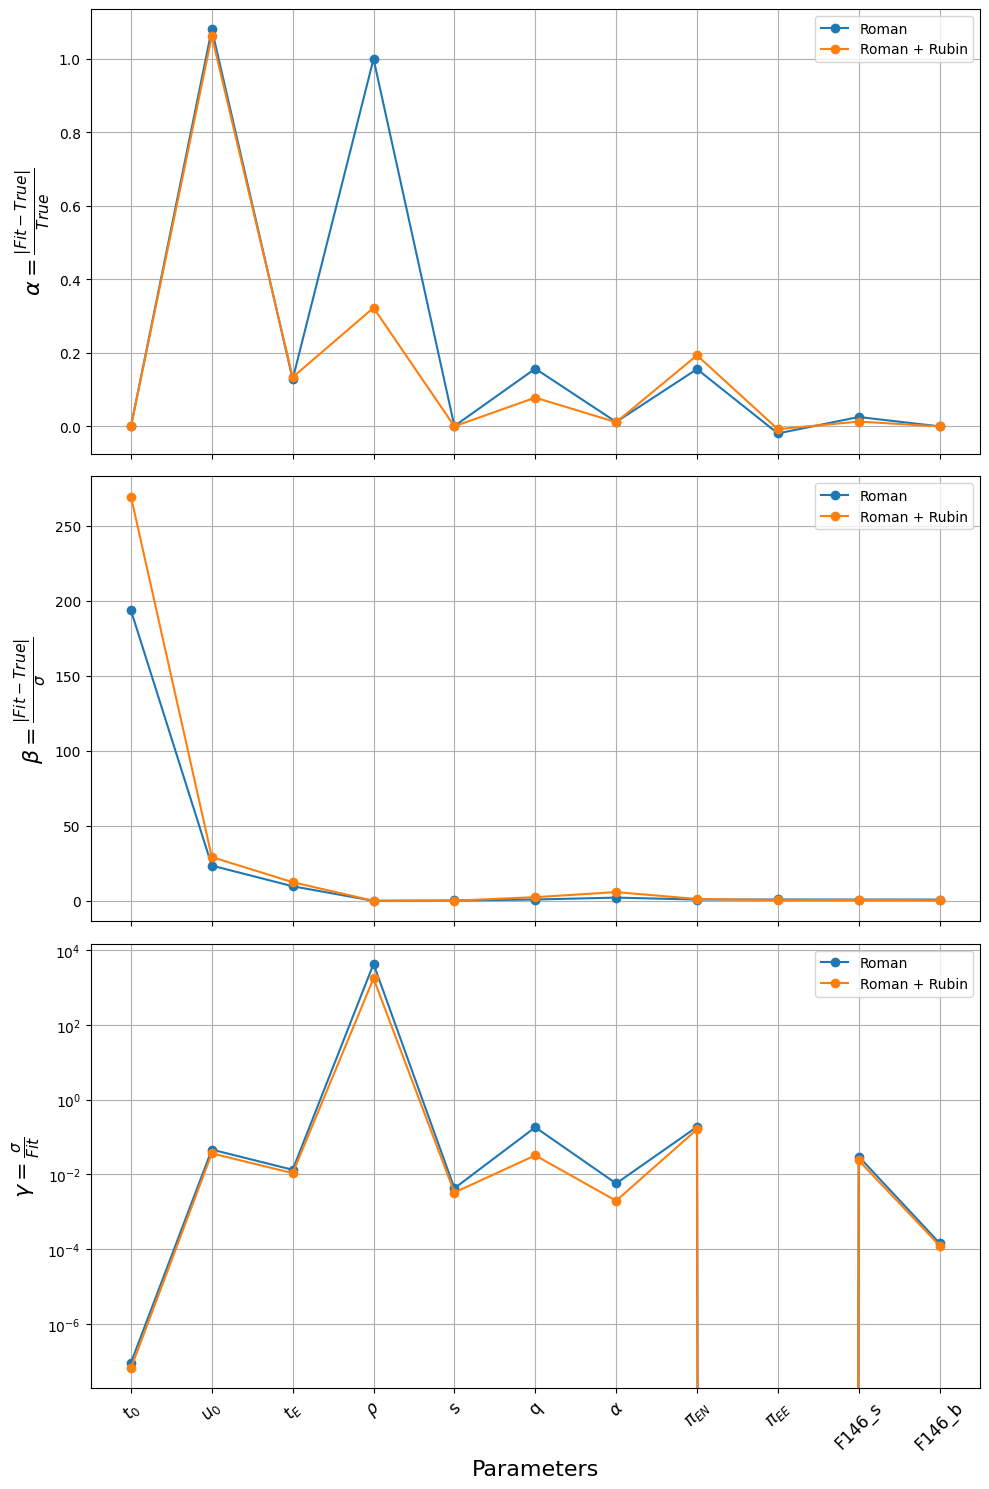

In [18]:
# Parameter labels
xticks = [r'$t_0$', r'$u_0$', r'$t_E$', r'$\rho$', 's', 'q', r'$\alpha$', r'$\pi_{EN}$', r'$\pi_{EE}$', 'F146_s', 'F146_b']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot alpha
axs[0].plot(alpha_roman, marker='o', label='Roman')
axs[0].plot(alpha_rr, marker='o', label='Roman + Rubin')
axs[0].set_ylabel(r'$\alpha = \frac{|Fit-True|}{True}$', fontsize=16)
axs[0].legend()
axs[0].grid(True)

# Plot beta
axs[1].plot(beta_roman, marker='o', label='Roman')
axs[1].plot(beta_rr, marker='o', label='Roman + Rubin')
axs[1].set_ylabel(r'$\beta =\frac{|Fit-True|}{\sigma}$', fontsize=16)
axs[1].legend()
axs[1].grid(True)

# Plot gamma
axs[2].plot(gamma_roman, marker='o', label='Roman')
axs[2].plot(gamma_rr, marker='o', label='Roman + Rubin')
axs[2].set_ylabel(r'$\gamma =\frac{\sigma}{Fit}$', fontsize=16)
axs[2].legend()
axs[2].set_yscale('log')
axs[2].grid(True)

# Shared x-axis
plt.xticks(ticks=range(len(xticks)), labels=xticks, rotation=45, fontsize=12)
axs[2].set_xlabel('Parameters', fontsize=16)

plt.tight_layout()
plt.show()


In [15]:
# just a definition
model_rr = pyLIMAmodel_rr
model_roman = pyLIMAmodel_roman

data_fit_roman = fit_roman.fit_results
data_fit_rr = fit_rr.fit_results

## Plot fitted events

In this event I saw some structure in the residuals that indicate that the model is not fitting the data

In [16]:
plt.close('all')

# custom_cycler = (cycler(color=custom_color))
# pyLIMA_plots.MARKERS_COLORS = custom_cycler
# pyLIMA_plots.MARKER_SYMBOLS = np.array([custom_marker])
### Find the telescope fluxes if needed

if len(data_fit_rr['best_model']) != len(model_rr.model_dictionnary):
    telescopes_fluxes = model_rr.find_telescopes_fluxes(data_fit_rr['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters1 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters1 = data_fit_rr['best_model']

    
if len(data_fit_roman['best_model']) != len(model_roman.model_dictionnary):
    telescopes_fluxes = model_roman.find_telescopes_fluxes(data_fit_roman['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters2 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters2 = data_fit_rr['best_model']


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100809 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100809 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 82169 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 82169 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 82169 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope g: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100469 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100469 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS


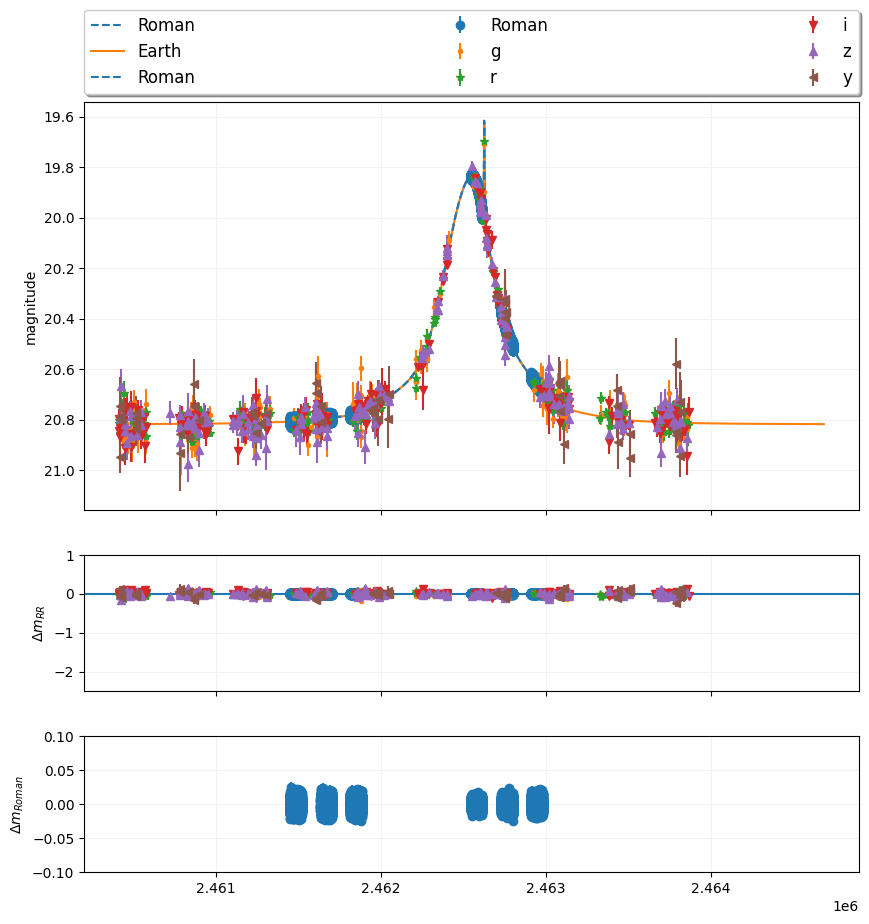

In [17]:
# tmin, tmax = 2460200., data_ogle[-1,0]+5.
# tmin, tmax = 2460160., data_ogle[-1,0]+20.

%matplotlib inline
fig, axes = plt.subplots(3, 1,figsize=(10,10), height_ratios=[3, 1,1], sharex=True)

# Lc plot
# axes[0].title.set_text('name')
axes[0].set_ylabel("magnitude") 
axes[0].grid(True, color='0.95')
axes[0].invert_yaxis()
# axes[0].set_xlim(tmin, tmax)
# axes[0].set_ylim(18.5, 12.5)
# axes[0].set_ylim(17.5, 12.5)

#Plot model1 and align data to it
pyLIMA_plots.plot_photometric_models(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_photometric_models(axes[0], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

# for i in range(len(spec_jds)):
#     axes[0].axvline(x=spec_jds[i], label='Spec_'+str(i), ls='--', color=colors[i])

# plot residuals
axes[1].set_ylabel("$\Delta m_{RR} $") 
axes[1].grid(True, color='0.95')
axes[2].set_ylabel("$\Delta m_{Roman} $") 
axes[2].grid(True, color='0.95')

pyLIMA_plots.plot_residuals(axes[1], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_residuals(axes[2], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
# axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(-2.5, 1)
axes[1].axhline(y=0)

# for i in range(len(spec_jds)):
#     axes[1].axvline(x=spec_jds[i], ls='--', color=colors[i])

axes[0].legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()
